# Video Time Series Data Extraction

In [6]:
import numpy as np
import csv
from collections import defaultdict
import os 
import cv2
from matplotlib import pyplot as plt


In [ ]:
INPUT_PATH = "/home/snt/projects_lujun/benchmarking_nature_tsfm/data/video/LaSOT/swing/swing/swing-14/img"  # 可以是 "video.mp4" / 0 (摄像头) / "frames_folder"

MAX_CORNERS = 30
QUALITY_LEVEL = 0.05
MIN_DISTANCE = 12
BLOCK_SIZE = 3
USE_HARRIS = False  #  useHarrisDetector=True → 使用 Harris 角点检测  useHarrisDetector=False 使用 Shi-Tomasi 角点检测
K_HARRIS = 0.04  # If useHarrisDetector, don't set it

WIN_SIZE = (40, 40)  ## Original size 21 21 
MAX_LEVEL = 3
TERM_CRITERIA = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01)

REDETECT_INTERVAL = 50  
FB_ERR_THRESH = 50.0 # Original 1.5  
ERR_THRESH = 80.0  # Original 30.0

DRAW_TRAJ_LEN = 100      
OUTPUT_CSV = "tracks.csv" 


In [ ]:
# ========== 统一的帧读取器 ==========
class FrameReader:
    def __init__(self, input_path):
        if isinstance(input_path, int) or input_path.endswith(".mp4") or input_path.endswith(".avi"):
            # 摄像头或视频
            self.mode = "video"
            self.cap = cv2.VideoCapture(input_path)
        elif os.path.isdir(input_path):
            # 图片文件夹
            self.mode = "images"
            files = sorted(os.listdir(input_path))
            self.files = [os.path.join(input_path, f) for f in files if f.lower().endswith((".png", ".jpg", ".jpeg"))]
            self.idx = 0
        else:
            raise ValueError("输入路径不合法: 既不是视频/摄像头，也不是图片文件夹")

    def read(self):
        if self.mode == "video":
            return self.cap.read()
        elif self.mode == "images":
            if self.idx >= len(self.files):
                return False, None
            frame = cv2.imread(self.files[self.idx])
            # print (self.idx)
            self.idx += 1
            return frame is not None, frame

    def release(self):
        if self.mode == "video":
            self.cap.release()
        

fgbg = cv2.createBackgroundSubtractorMOG2(
    history=200,       # 让背景模型更快适应变化
    varThreshold=25,   # 提高阈值，减少噪声
    detectShadows=False # 不检测阴影，掩码更干净
)

def detect_features(frame, max_corners=200):

    fgmask = fgbg.apply(frame)
    fgmask = cv2.medianBlur(fgmask, 5)  

    pts = cv2.goodFeaturesToTrack(
        frame,
        maxCorners=max_corners,
        qualityLevel=0.01,
        minDistance=10,
        mask=fgmask
    )
    return np.float32(pts) if pts is not None else np.empty((0,1,2), dtype=np.float32)



## 
def forward_backward_check(prev_gray, curr_gray, p0):
    # 正向
    p1, st1, err1 = cv2.calcOpticalFlowPyrLK(
        prev_gray, curr_gray, p0, None,
        winSize=WIN_SIZE, maxLevel=MAX_LEVEL, criteria=TERM_CRITERIA
    )
    # 反向
    p0_back, st2, err2 = cv2.calcOpticalFlowPyrLK(
        curr_gray, prev_gray, p1, None,
        winSize=WIN_SIZE, maxLevel=MAX_LEVEL, criteria=TERM_CRITERIA
    )
    # 前后向误差
    fb_err = np.linalg.norm(p0 - p0_back, axis=2).reshape(-1)
    err1_ = err1.reshape(-1) if err1 is not None else np.full(len(p0), np.inf)
    st = (st1.reshape(-1) == 1) & (st2.reshape(-1) == 1)
    return p1, st, fb_err, err1_

def in_bounds(p, w, h):
    x, y = p[:,0], p[:,1]
    return (x >= 0) & (x < w) & (y >= 0) & (y < h)


In [9]:
# ========== 主流程 ==========
# cap = cv2.VideoCapture(VIDEO_PATH)

reader = FrameReader(INPUT_PATH)
ok, frame0 = reader.read()
if not ok:
    raise RuntimeError("无法读取输入")

# 记录视频尺寸 h，w， 把首帧转为灰度
h, w = frame0.shape[:2]
prev_gray = cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY)


fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
out = cv2.VideoWriter('output.mp4', fourcc, 10, (w, h))  


KeyboardInterrupt: 

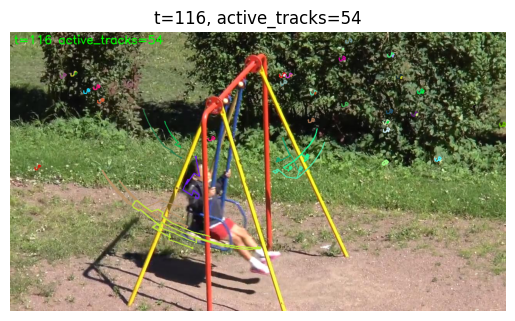

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


# 初始化角点与轨迹容器
p0 = detect_features(prev_gray, max_corners=MAX_CORNERS)
next_track_id = 0
# 为每个点分配一个track_id
active_ids = []
tracks = defaultdict(list)  # track_id -> [(t,x,y)]
colors = {}

def add_points(points, t):
    global next_track_id
    for pt in points.reshape(-1,2):
        tracks[next_track_id].append((t, float(pt[0]), float(pt[1])))
        active_ids.append(next_track_id)
        colors[next_track_id] = tuple(np.random.randint(0, 255, 3).tolist())
        next_track_id += 1

## 初始化第一帧所识别的所有角点
add_points(p0, t=0)
t = 0

# 用于可视化的轨迹缓存（只保留最近 DRAW_TRAJ_LEN 个）
vis_traj = defaultdict(list)  # track_id -> [(x,y), ...]

plt.ion()  # interactive mode
fig, ax = plt.subplots()

while True:
    ok, frame = reader.read()
    if not ok:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    t += 1
    # print (t)
    # 若还有活跃轨迹：光流跟踪 + 质量筛选 + 更新
    if len(active_ids) > 0:
        # 组织上一帧的点坐标数组（与 active_ids 顺序一致）
        p0_arr = []
        for tid in active_ids:
            xlast, ylast = tracks[tid][-1][1], tracks[tid][-1][2]
            p0_arr.append([xlast, ylast])
        p0_arr = np.float32(p0_arr).reshape(-1,1,2)

        # LK + 前后向一致性
        p1, st, fb_err, err1_ = forward_backward_check(prev_gray, gray, p0_arr)  ## 正向估计新位置，反向验证， p1：本帧估计的新位置 st：前后向都成功的布尔标记 fb_err：前后向回投误差 err1_：正向 LK 误差

        # 质量筛选
        st = st & (fb_err < FB_ERR_THRESH) & (err1_ < ERR_THRESH)
        st = st & in_bounds(p1.reshape(-1,2), w, h)

        # 更新轨迹
        new_active_ids = []
        p1_flat = p1.reshape(-1,2)
        for keep, tid, new_pt in zip(st, active_ids, p1_flat):
            if keep:
                tracks[tid].append((t, float(new_pt[0]), float(new_pt[1])))
                new_active_ids.append(tid)
                # 更新可视化缓存
                vis_traj[tid].append((int(new_pt[0]), int(new_pt[1])))
                if len(vis_traj[tid]) > DRAW_TRAJ_LEN:
                    vis_traj[tid] = vis_traj[tid][-DRAW_TRAJ_LEN:]
        active_ids = new_active_ids

    # 周期性补点（避免与已有点太近）
    if t % REDETECT_INTERVAL == 0:
        mask = np.full((h, w), 255, dtype=np.uint8)
        for tid in active_ids:
            x, y = tracks[tid][-1][1], tracks[tid][-1][2]
            cv2.circle(mask, (int(x), int(y)), MIN_DISTANCE, 0, -1)
        new_pts = detect_features(gray, max_corners=MAX_CORNERS // 2)
        if new_pts is not None and len(new_pts) > 0:
            add_points(new_pts, t)

    vis = frame.copy()
    for tid in active_ids:
        c = colors[tid]
        pts_list = vis_traj[tid]
        for i in range(1, len(pts_list)):
            cv2.line(vis, pts_list[i-1], pts_list[i], c, 2)
        if len(pts_list) > 0:
            cv2.circle(vis, pts_list[-1], 3, c, -1)

    cv2.putText(vis, f"t={t} active_tracks={len(active_ids)}",
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 2)

    # ---- 用 matplotlib 显示 ----
    # ax.clear()
    # ax.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    # ax.set_title(f"t={t}, active_tracks={len(active_ids)}")
    # ax.axis("off")
    # plt.pause(0.01)
    # print ("hello")
    # prev_gray = gray
    out.write(vis)
    clear_output(wait=True)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(f"t={t}, active_tracks={len(active_ids)}")
    plt.axis("off")
    display(plt.gcf())            
    plt.pause(0.1)
    prev_gray = gray

out.release() 
plt.ioff()
plt.show()

# 导出轨迹到 CSV：列为 track_id, t, x, y
with open(OUTPUT_CSV, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["track_id", "t", "x", "y"])
    for tid, seq in tracks.items():
        for (tt, xx, yy) in seq:
            writer.writerow([tid, tt, f"{xx:.3f}", f"{yy:.3f}"])
    print(f"Save_to: {OUTPUT_CSV}")



In [5]:

import pandas as pd
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt


# input_path = "/home/snt/projects_lujun/benchmarking_nature_tsfm/data/video/LaSOT/swing/swing/swing-14/tracks_ts20250821_112240.csv"
# result_df = pd.read_csv(input_path)


def interpolate_track(track_df, n_points=50):
    t = np.linspace(0, 1, len(track_df))
    t_new = np.linspace(0, 1, n_points)
    x_new = np.interp(t_new, t, track_df['x'].values)
    y_new = np.interp(t_new, t, track_df['y'].values)
    return np.stack([x_new, y_new], axis=1)

def euclidean_distance_matrix(trajs):
    n = len(trajs)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist = np.linalg.norm(trajs[i] - trajs[j])
            dist_matrix[i, j] = dist_matrix[j, i] = dist
    return dist_matrix

def select_most_diverse_tracks(df, max_tracks=5, top_k=10):
    longest_track_len = df.groupby("track_id").size().max()
    track_lengths = df.groupby("track_id").size()
    top_ids = track_lengths.sort_values(ascending=False).head(top_k).index 
    df_top = df[df["track_id"].isin(top_ids)] .copy()

    traj_dict = {}
    interpolated_rows = []
    for track_id, track in df_top.groupby("track_id"):
        traj = interpolate_track(track, n_points=longest_track_len)
        traj_dict[track_id] = traj
        for i, (x, y) in enumerate(traj):
            interpolated_rows.append({
                "track_id": track_id,
                "t": i,
                "x": x,
                "y": y
            })
    df_interpolated = pd.DataFrame(interpolated_rows)
    
    track_ids = list(traj_dict.keys())
    
    dist_matrix = euclidean_distance_matrix(list(traj_dict.values()))
    
    selected = [0]
    n = len(track_ids)
    while len(selected) < min(max_tracks, n):
        remaining = [i for i in range(n) if i not in selected]
        avg_dists = [np.mean([dist_matrix[i, j] for j in selected]) for i in remaining]
        next_idx = remaining[np.argmax(avg_dists)]
        selected.append(next_idx)
    
    selected_ids = [track_ids[i] for i in selected]
    df_selected = df[df["track_id"].isin(selected_ids)].copy()
    df_interpolated_selected = df_interpolated[df_interpolated["track_id"].isin(selected_ids)].copy()

    return df_selected, df_interpolated, df_interpolated_selected

def plot_tracks(df):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for track_id, track in df.groupby("track_id"):
        axes[0].plot(track["t"], track["x"], label=f"track {track_id}")
        axes[1].plot(track["t"], track["y"], label=f"track {track_id}")

    axes[0].set_title("X vs t")
    axes[0].set_xlabel("t")
    axes[0].set_ylabel("x")

    axes[1].set_title("Y vs t")
    axes[1].set_xlabel("t")
    axes[1].set_ylabel("y")

    axes[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


# df_reduced, df_interpolated, df_interpolated_selected = select_most_diverse_tracks(result_df, max_tracks=5, top_k=20)

# Collect Datasets and Build it on Huggingface

In [9]:
import os
import re
import pandas as pd

folder_path = "/home/snt/projects_lujun/benchmarking_nature_tsfm/data/video/collected_csvs" 
output_folder_path = "/home/snt/projects_lujun/benchmarking_nature_tsfm/data/video/processed_csvs_interpolated"
output_folder_path_reduced = "/home/snt/projects_lujun/benchmarking_nature_tsfm/data/video/processed_csvs_reduced"

for filename in os.listdir(folder_path):
    print (filename)
    if filename.endswith(".csv"):
        input_path = os.path.join(folder_path, filename)

        result_df = pd.read_csv(input_path)

        df_reduced, df_interpolated, df_interpolated_selected = select_most_diverse_tracks(
            result_df, max_tracks=5, top_k=20
        )

        match = re.match(r"([a-zA-Z0-9_]+)_tracks_ts(\d{8}_\d{6})", filename)
        if match:
            prefix = match.group(1)  # airplane_1
            timestamp = match.group(2)  # 20250821_122106
        else:
            prefix = "unknown"
            timestamp = "unknown"

        df_interpolated_selected["prefix"] = prefix
        df_interpolated_selected["timestamp"] = timestamp
        df_reduced["prefix"] = prefix
        df_reduced["timestamp"] = timestamp
        df_interpolated_selected.to_json(os.path.join(output_folder_path, f"{prefix}_interpolated_{timestamp}.jsonl"), orient="records", lines=True)
        df_reduced.to_json(os.path.join(output_folder_path_reduced, f"{prefix}_reduced_{timestamp}.jsonl"), orient="records", lines=True)



swing_8_tracks_ts20250821_200737.csv
lion_8_tracks_ts20250821_201708.csv
book_15_tracks_ts20250821_124111.csv
goldfish_17_tracks_ts20250821_194049.csv
gorilla_3_tracks_ts20250821_212628.csv
cattle_13_tracks_ts20250821_130619.csv
pig_12_tracks_ts20250821_192521.csv
crab_10_tracks_ts20250821_140645.csv
rubicCube_14_tracks_ts20250821_192618.csv
lizard_9_tracks_ts20250821_213006.csv
deer_8_tracks_ts20250821_132245.csv
airplane_18_tracks_ts20250821_132713.csv
electricfan_2_tracks_ts20250821_204048.csv
hippo_20_tracks_ts20250821_212223.csv
fox_9_tracks_ts20250821_204909.csv
dog_4_tracks_ts20250821_191856.csv
cat_7_tracks_ts20250821_122952.csv
boat_12_tracks_ts20250821_143457.csv
hippo_14_tracks_ts20250821_213043.csv
racing_12_tracks_ts20250821_201209.csv
airplane_16_tracks_ts20250821_123202.csv
coin_14_tracks_ts20250821_135636.csv
rubicCube_15_tracks_ts20250821_195212.csv
crocodile_13_tracks_ts20250821_124146.csv
crocodile_14_tracks_ts20250821_124200.csv
bottle_19_tracks_ts20250821_131619.cs

In [ ]:
import pandas as pd 


df= pd.read_json("/home/snt/projects_lujun/benchmarking_nature_tsfm/data/video/processed_csvs_interpolated/airplane_1_interpolated_20250821_122106.jsonl", lines=True)


def extract_df_2_time_series (df):
    rows = []
    track_id_list = df.track_id.unique().tolist()
    for track_id in track_id_list:
        row_x = pd.DataFrame()
        track_data = df[df.track_id == track_id]
        df["timestamp"] = track_data.timestamp.values[0]
        df["prefix"] = track_data.prefix.values[0]
        t_list = df["t"].tolist()
        x_list = df["x"].tolist()
        y_list = df["y"].tolist()
        row_x["t"] = t_list
        row_x["x"] = x_list
        row_x["axis"] = "x"
        row_x["track_id"] = track_id
        row_x["timestamp"] = track_data.timestamp.values[0]
        row_x["prefix"] = track_data.prefix.values[0]
        rows.append(row_x)

        row_y = pd.DataFrame()
        row_y["t"] = t_list
        row_y["y"] = y_list
        row_y["axis"] = "y"
        row_y["track_id"] = track_id
        row_y["timestamp"] = track_data.timestamp.values[0]
        row_y["prefix"] = track_data.prefix.values[0]
        rows.append(row_y)

    return pd.concat(rows, ignore_index=True)




In [22]:
import os
import pandas as pd

folder_path = "/home/snt/projects_lujun/benchmarking_nature_tsfm/data/video/processed_csvs_interpolated"

def extract_df_2_time_series(df):
    rows = []
    track_id_list = df.track_id.unique().tolist()
    for track_id in track_id_list:
        row_x = pd.DataFrame()
        track_data = df[df.track_id == track_id]

        t_list = track_data["t"].tolist()
        x_list = track_data["x"].tolist()
        y_list = track_data["y"].tolist()

        row_x["t"] = [t_list]
        row_x["target"] = [x_list]
        row_x["axis"] = "x"
        row_x["track_id"] = track_id
        row_x["timestamp"] = track_data.timestamp.values[0]
        row_x["prefix"] = track_data.prefix.values[0]
        rows.append(row_x)

        row_y = pd.DataFrame()
        row_y["t"] = [t_list]
        row_y["target"] = [y_list]
        row_y["axis"] = "y"
        row_y["track_id"] = track_id
        row_y["timestamp"] = track_data.timestamp.values[0]
        row_y["prefix"] = track_data.prefix.values[0]
        rows.append(row_y)

    return rows

all_dfs = []

for filename in os.listdir(folder_path):
    if filename.endswith(".jsonl"):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_json(file_path, lines=True)
        processed_list = extract_df_2_time_series(df)
        for processed_row in processed_list:
            all_dfs.append(processed_row)

if all_dfs:
    final_df = pd.concat(all_dfs, ignore_index=True)
else:
    final_df = pd.DataFrame()

print(final_df.head())


                                                   t  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                              target axis  track_id  \
0  [239.0, 240.941, 241.711, 241.828, 239.508, 23...    x        18   
1  [184.0, 186.796, 189.69, 191.364, 189.201, 184...    y        18   
2  [194.0, 192.6425522101, 192.4428007687, 191.87...    x       140   
3  [178.0, 180.0969865471, 180.3169801409, 179.16...    y       140   
4  [128.0, 126.0242511211, 123.6163875721, 120.95...    x       166   

                   timestamp   prefix  
0 1970-08-23 09:13:41.141208  bird_15  
1 1970-08-23 09:13:41.141208  bird_15  
2 1970-08-23 09:13:41.141208  bird_15  
3 1970-08-23 09:13:41.141208  bird_15  
4 1970-08-23 09:13:41.141208  bird_1

In [ ]:
from datasets import Dataset
from huggingface_hub import HfApi

hf_dataset = Dataset.from_pandas(final_df)
api = HfApi(token="")

repo_id = "Volavion/real-v-tsfm"
try:
    api.create_repo(repo_id=repo_id, repo_type="dataset")
except Exception as e:
    print(f"仓库可能已存在，跳过创建: {e}")

hf_dataset.push_to_hub(repo_id, token="")


/home/snt/projects_lujun/benchmarking_nature_tsfm/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Creating parquet from Arrow format: 100%|██████████| 9/9 [00:01<00:00,  8.03ba/s]
Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

Processing Files (0 / 1)                :   0%|          |  550kB /  120MB,  551kB/s  
Processing Files (0 / 1)                :   2%|▏         | 2.75MB /  120MB, 2.29MB/s  
Processing Files (0 / 1)                :   5%|▌         | 6.06MB /  120MB, 4.33MB/s  
Processing Files (0 / 1)                :  10%|▉         | 11.6MB /  120MB, 7.23MB/s  
Processing Files (0 / 1)                :  18%|█▊        | 21.5MB /  120MB, 11.9MB/s  
Processing Files (0 / 1)                :  28%|██▊       | 34.2MB /  120MB, 17.1MB/s  
Processing Files (0 / 

CommitInfo(commit_url='https://huggingface.co/datasets/Volavion/real-v-tsfm/commit/8b92f8000e337cc5821f123379c278ec8406c9ec', commit_message='Upload dataset', commit_description='', oid='8b92f8000e337cc5821f123379c278ec8406c9ec', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Volavion/real-v-tsfm', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Volavion/real-v-tsfm'), pr_revision=None, pr_num=None)

In [31]:
final_df.to_json("/home/snt/projects_lujun/benchmarking_nature_tsfm/data/dataset/real-v-tsfm.jsonl", orient="records", lines=True)

In [8]:
import pandas as pd

final_df = pd.read_json("/home/snt/projects_lujun/benchmarking_nature_tsfm/data/dataset/real-v-tsfm.jsonl", lines =True)

In [9]:
len(final_df)

8440

In [10]:

final_df = final_df[final_df["target"].apply(lambda x: len(x) >= 1000)].reset_index(drop=True)


In [14]:
final_df.to_json("/home/snt/projects_lujun/benchmarking_nature_tsfm/data/dataset/real-v-tsfm-shortened.jsonl", orient="records", lines=True)

In [12]:
import pandas as pd

# 假设 final_df 已经加载

# 轨迹数量
num_tracks = final_df['track_id'].nunique()

# prefix类型数量
num_prefixes = final_df['prefix'].nunique()

# 每条轨迹的时间长度（t 列是列表，每个单元格是时间序列）
final_df['time_length'] = final_df['t'].apply(len)

# 时间长度的统计指标
time_length_stats = final_df['time_length'].describe()

# timestamp 分布（时间范围）
timestamps = pd.to_datetime(final_df['timestamp'].unique())
min_timestamp = timestamps.min()
max_timestamp = timestamps.max()

# 统计target值的长度 as sanity check
final_df['target_length'] = final_df['target'].apply(len)
target_length_stats = final_df['target_length'].describe()

# target数值统计指标，先把所有target列表展开
import numpy as np

all_targets = np.concatenate(final_df['target'].values)

target_stats = {
    "mean": np.mean(all_targets),
    "std": np.std(all_targets),
    "min": np.min(all_targets),
    "max": np.max(all_targets)
}

print(f"轨迹总数量: {num_tracks}")
print(f"prefix类型数量: {num_prefixes}")
print("\n时间长度统计(每轨迹的时间点数):")
print(time_length_stats)

print(f"\n时间戳范围: {min_timestamp} 至 {max_timestamp}")

print("\ntarget长度统计(每轨迹目标序列长度):")
print(target_length_stats)

print("\ntarget数值统计指标:")
for k, v in target_stats.items():
    print(f"{k}: {v:.4f}")


轨迹总数量: 560
prefix类型数量: 609

时间长度统计(每轨迹的时间点数):
count    6130.000000
mean     2043.270799
std      1053.719425
min      1000.000000
25%      1341.000000
50%      1727.000000
75%      2357.000000
max      8000.000000
Name: time_length, dtype: float64

时间戳范围: 1970-08-23 09:13:41.121000 至 1970-08-23 09:13:41.213000

target长度统计(每轨迹目标序列长度):
count    6130.000000
mean     2043.270799
std      1053.719425
min      1000.000000
25%      1341.000000
50%      1727.000000
75%      2357.000000
max      8000.000000
Name: target_length, dtype: float64

target数值统计指标:
mean: 402.1262
std: 281.4630
min: 0.0070
max: 1279.9760


In [13]:
import pandas as pd
import numpy as np

# 假设 final_df 已经加载

# 使用行索引作为唯一标识
final_df['unique_id'] = final_df.index

# 轨迹数量按行数计数
num_tracks = final_df.shape[0]

# prefix类型数量
num_prefixes = final_df['prefix'].nunique()

# 每条轨迹的时间长度（t 列是列表，每个单元格是时间序列）
final_df['time_length'] = final_df['t'].apply(len)
time_length_stats = final_df['time_length'].describe()
time_length_mean = final_df['time_length'].mean()
time_length_std = final_df['time_length'].std()
time_length_cv = time_length_std / time_length_mean

# timestamp 分布（时间范围）
timestamps = pd.to_datetime(final_df['timestamp'].unique())
min_timestamp = timestamps.min()
max_timestamp = timestamps.max()

# target长度统计
final_df['target_length'] = final_df['target'].apply(len)
target_length_stats = final_df['target_length'].describe()

# target数值整体统计
all_targets = np.concatenate(final_df['target'].values)
target_stats = {
    "mean": np.mean(all_targets),
    "std": np.std(all_targets),
    "min": np.min(all_targets),
    "max": np.max(all_targets)
}

# 基于唯一id，计算轨迹均值，反映数值多样性
mean_per_track = final_df.groupby('unique_id')['target'].apply(lambda x: np.mean(np.concatenate(x.values)))
mean_per_track_std = mean_per_track.std()

# 输出统计
print(f"轨迹总数量（行数）: {num_tracks}")
print(f"prefix 类型数量: {num_prefixes}\n")

print("时间长度统计 (每轨迹时间点数量):")
print(time_length_stats)
print(f"时间长度均值: {time_length_mean:.2f}")
print(f"时间长度标准差: {time_length_std:.2f}")
print(f"时间长度变异系数 (CV): {time_length_cv:.4f}\n")

print(f"时间戳范围: {min_timestamp} 至 {max_timestamp}\n")

print("target 长度统计 (每轨迹目标序列长度):")
print(target_length_stats)
print()

print("target 数值统计指标:")
for k, v in target_stats.items():
    print(f"{k}: {v:.4f}")
print()

print(f"轨迹均值的标准差（轨迹值均值差异指标，多样性反映）: {mean_per_track_std:.4f}")


轨迹总数量（行数）: 6130
prefix 类型数量: 609

时间长度统计 (每轨迹时间点数量):
count    6130.000000
mean     2043.270799
std      1053.719425
min      1000.000000
25%      1341.000000
50%      1727.000000
75%      2357.000000
max      8000.000000
Name: time_length, dtype: float64
时间长度均值: 2043.27
时间长度标准差: 1053.72
时间长度变异系数 (CV): 0.5157

时间戳范围: 1970-08-23 09:13:41.121000 至 1970-08-23 09:13:41.213000

target 长度统计 (每轨迹目标序列长度):
count    6130.000000
mean     2043.270799
std      1053.719425
min      1000.000000
25%      1341.000000
50%      1727.000000
75%      2357.000000
max      8000.000000
Name: target_length, dtype: float64

target 数值统计指标:
mean: 402.1262
std: 281.4630
min: 0.0070
max: 1279.9760

轨迹均值的标准差（轨迹值均值差异指标，多样性反映）: 265.1100


In [ ]:
import numpy as np

def simple_moving_average_forecast(series, window_size, horizon):
    series = np.asarray(series)
    if window_size <= 0 or horizon <= 0:
        raise ValueError("window_size 和 horizon 必须是正整数")
    if len(series) < window_size:
        raise ValueError("时间序列长度必须至少等于窗口大小")

    last_window_avg = np.mean(series[-window_size:])
    forecast = np.full(horizon, last_window_avg)

    return forecast

